In [1]:
#importing all necessary libraries(numpy, os, cv2, matplolib, keras)
import numpy as np
import os
import cv2
from keras import layers
from keras.layers import Input, Dense, Add,Activation, AveragePooling2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout, ZeroPadding2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.initializers import glorot_uniform
from keras import regularizers
import scipy.misc
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


In [2]:
data_dir = '../input/sign-language-gesture-images-dataset/Gesture Image Data/'

In [3]:
#helper function to load_dataset of 50*50 pixels
def load_dataset(directory):
  images = []
  labels = []
  for idx,label in enumerate(uniq_labels):
    for file in os.listdir(directory + label):
      filepath = directory + label +"/" + file
      img = cv2.resize(cv2.imread(filepath),(50,50))
      images.append(img)
      labels.append(idx)
  images = np.asarray(images)
  labels = np.asarray(labels)
  return images, labels

In [4]:
#Helper function to print images
def display_images(x_data,y_data, title, display_label = True):
    x, y = x_data,y_data
    fig, axes = plt.subplots(5, 8, figsize = (18, 5))
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    fig.suptitle(title, fontsize = 18)
    for i, ax in enumerate(axes.flat):
        ax.imshow(x[i])
        if display_label:
            ax.set_xlabel(uniq_labels[y[i]])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [5]:
#loading_dataset into X_pre and Y_pre
uniq_labels = sorted(os.listdir(data_dir))
X_pre, Y_pre = load_dataset(data_dir)
print(X_pre.shape, Y_pre.shape)

(55500, 50, 50, 3) (55500,)


Train images shape (52725, 50, 50, 3) (52725,)
Test images shape (2719, 50, 50, 3) (2719,)
Evaluate image shape (56, 50, 50, 3) (56,)
Printing the labels ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_'] 37


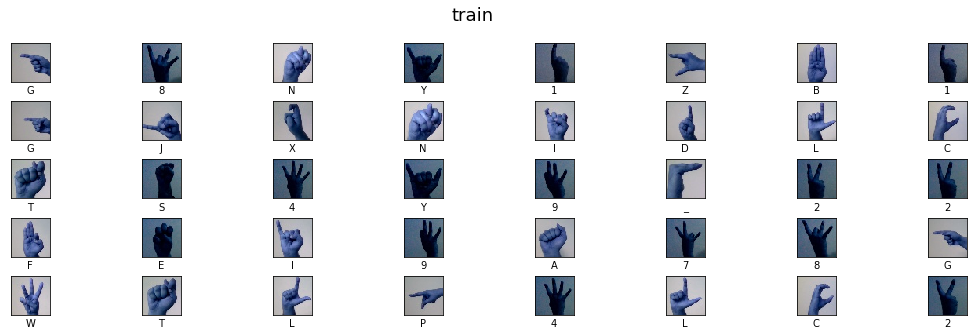

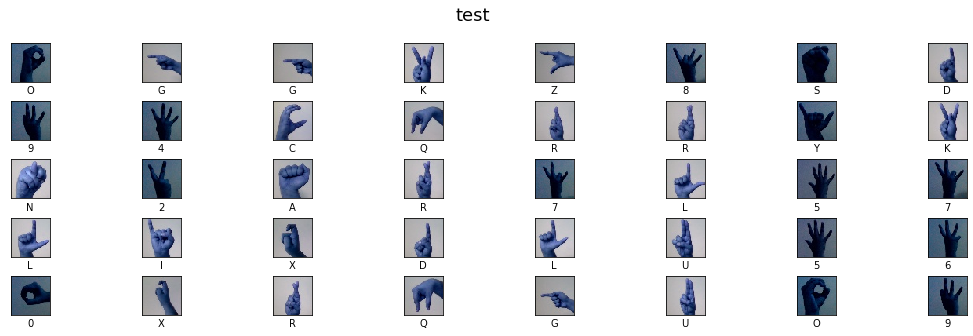

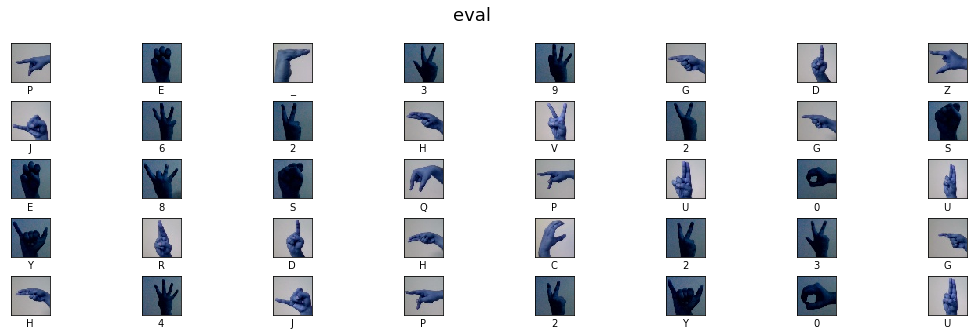

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pre, Y_pre, test_size = 0.05)
X_test, X_eval, Y_test, Y_eval = train_test_split(X_test, Y_test, test_size = 0.02)
print("Train images shape",X_train.shape, Y_train.shape)
print("Test images shape",X_test.shape, Y_test.shape)
print("Evaluate image shape",X_eval.shape, Y_eval.shape)
print("Printing the labels",uniq_labels, len(uniq_labels))
display_images(X_train,Y_train,'train')
display_images(X_test,Y_test,'test')
display_images(X_eval,Y_eval,'eval')

In [7]:
# converting Y_tes and Y_train to One hot vectors using to_categorical
# example of one hot => '1' is represented as [0. 1. 0. . . . . 0.]
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
Y_ev = to_categorical(Y_eval)
X_train = X_train / 255.
X_test = X_test/ 255.
X_eval = X_eval/ 255.

In [8]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [9]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f,f), strides = (1,1), name = conv_name_base + '2b', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1,1), strides = (1,1), name = conv_name_base + '2c', padding = 'valid', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3,(1,1),strides = (s,s), name = conv_name_base + '1',padding = 'valid', kernel_initializer = glorot_uniform(seed =0), kernel_regularizer=regularizers.l2(0.01))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3,name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [10]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (50, 50, 3), classes = 29):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((10, 10))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block = 'a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage = 3, block = 'b')
    X = identity_block(X, 3, [128,128,512], stage = 3, block = 'c')
    X = identity_block(X, 3, [128,128,512], stage = 3, block = 'd')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256,256,1024], stage = 4, block = 'a', s = 2)
    X = identity_block(X, 3, [256,256,1024], stage = 4, block = 'b')
    X = identity_block(X, 3, [256,256,1024], stage = 4, block = 'c')
    X = identity_block(X, 3, [256,256,1024], stage = 4, block = 'd')
    X = identity_block(X, 3, [256,256,1024], stage = 4, block = 'e')
    X = identity_block(X, 3, [256,256,1024], stage = 4, block = 'f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512,512,2048], stage = 5, block = 'a', s = 2)
    X = identity_block(X, 3, [512,512,2048], stage = 5, block = 'b')
    X = identity_block(X, 3, [512,512,2048], stage = 5, block = 'c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = 2 ,name= 'avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dropout(0.6)(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [11]:
model = ResNet50(input_shape = (50, 50, 3), classes = len(uniq_labels))

In [12]:
# compiling model with adam optimizer, categorical cross entropy 
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
# printing the summary of model
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

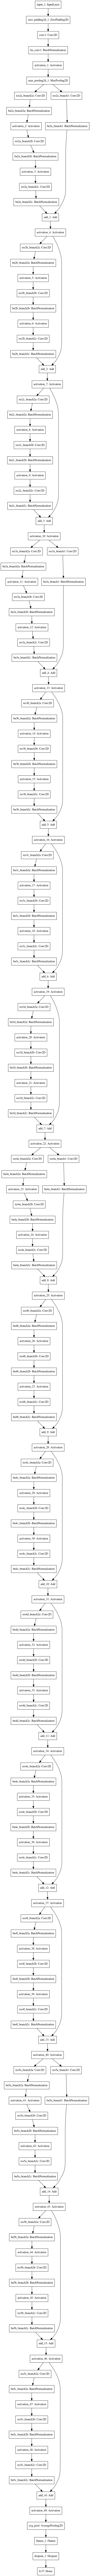

In [14]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [15]:
history = model.fit(X_train,Y_train, batch_size = 64, epochs = 5, shuffle = True, validation_data = (X_test,Y_test))

Train on 52725 samples, validate on 2719 samples
Epoch 1/5
52725/52725 [==============================] - 110s 2ms/step - loss: 5.9667 - accuracy: 0.9055 - val_loss: 1.6838 - val_accuracy: 0.9401
Epoch 2/5
52725/52725 [==============================] - 90s 2ms/step - loss: 0.9878 - accuracy: 0.9800 - val_loss: 0.5287 - val_accuracy: 0.9963
Epoch 3/5
52725/52725 [==============================] - 89s 2ms/step - loss: 0.4327 - accuracy: 0.9907 - val_loss: 0.2294 - val_accuracy: 0.9989
Epoch 4/5
52725/52725 [==============================] - 90s 2ms/step - loss: 0.3170 - accuracy: 0.9917 - val_loss: 0.1664 - val_accuracy: 0.9967
Epoch 5/5
52725/52725 [==============================] - 89s 2ms/step - loss: 0.3362 - accuracy: 0.9901 - val_loss: 0.1340 - val_accuracy: 0.9963


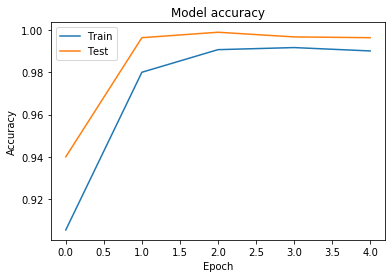

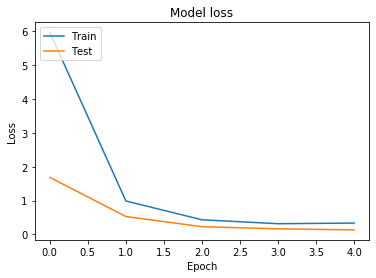

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
model.evaluate(X_eval,Y_ev)

56/56 [==============================] - 0s 5ms/step


[0.11762959616524833, 1.0]

In [18]:
#from keras.preprocessing import standardize
predictions = model.predict(X_eval)

In [19]:
predict = K.argmax(predictions,axis=-1)

pred = []
for i in predict:
    pred.append(uniq_labels[i])
print(pred)


['P', 'E', '_', '3', '9', 'G', 'D', 'Z', 'J', '6', '2', 'H', 'V', '2', 'G', 'S', 'E', '8', 'S', 'Q', 'P', 'U', '0', 'U', 'Y', 'R', 'D', 'H', 'C', '2', '3', 'G', 'H', '4', 'J', 'P', '2', 'Y', '0', 'U', 'Q', '8', '1', 'N', '2', 'L', '6', 'V', 'U', 'W', 'E', '3', 'A', '8', 'M', 'I']


In [20]:
Y = []
for i in Y_eval:
    Y.append(uniq_labels[i])
print(Y)

['P', 'E', '_', '3', '9', 'G', 'D', 'Z', 'J', '6', '2', 'H', 'V', '2', 'G', 'S', 'E', '8', 'S', 'Q', 'P', 'U', '0', 'U', 'Y', 'R', 'D', 'H', 'C', '2', '3', 'G', 'H', '4', 'J', 'P', '2', 'Y', '0', 'U', 'Q', '8', '1', 'N', '2', 'L', '6', 'V', 'U', 'W', 'E', '3', 'A', '8', 'M', 'I']


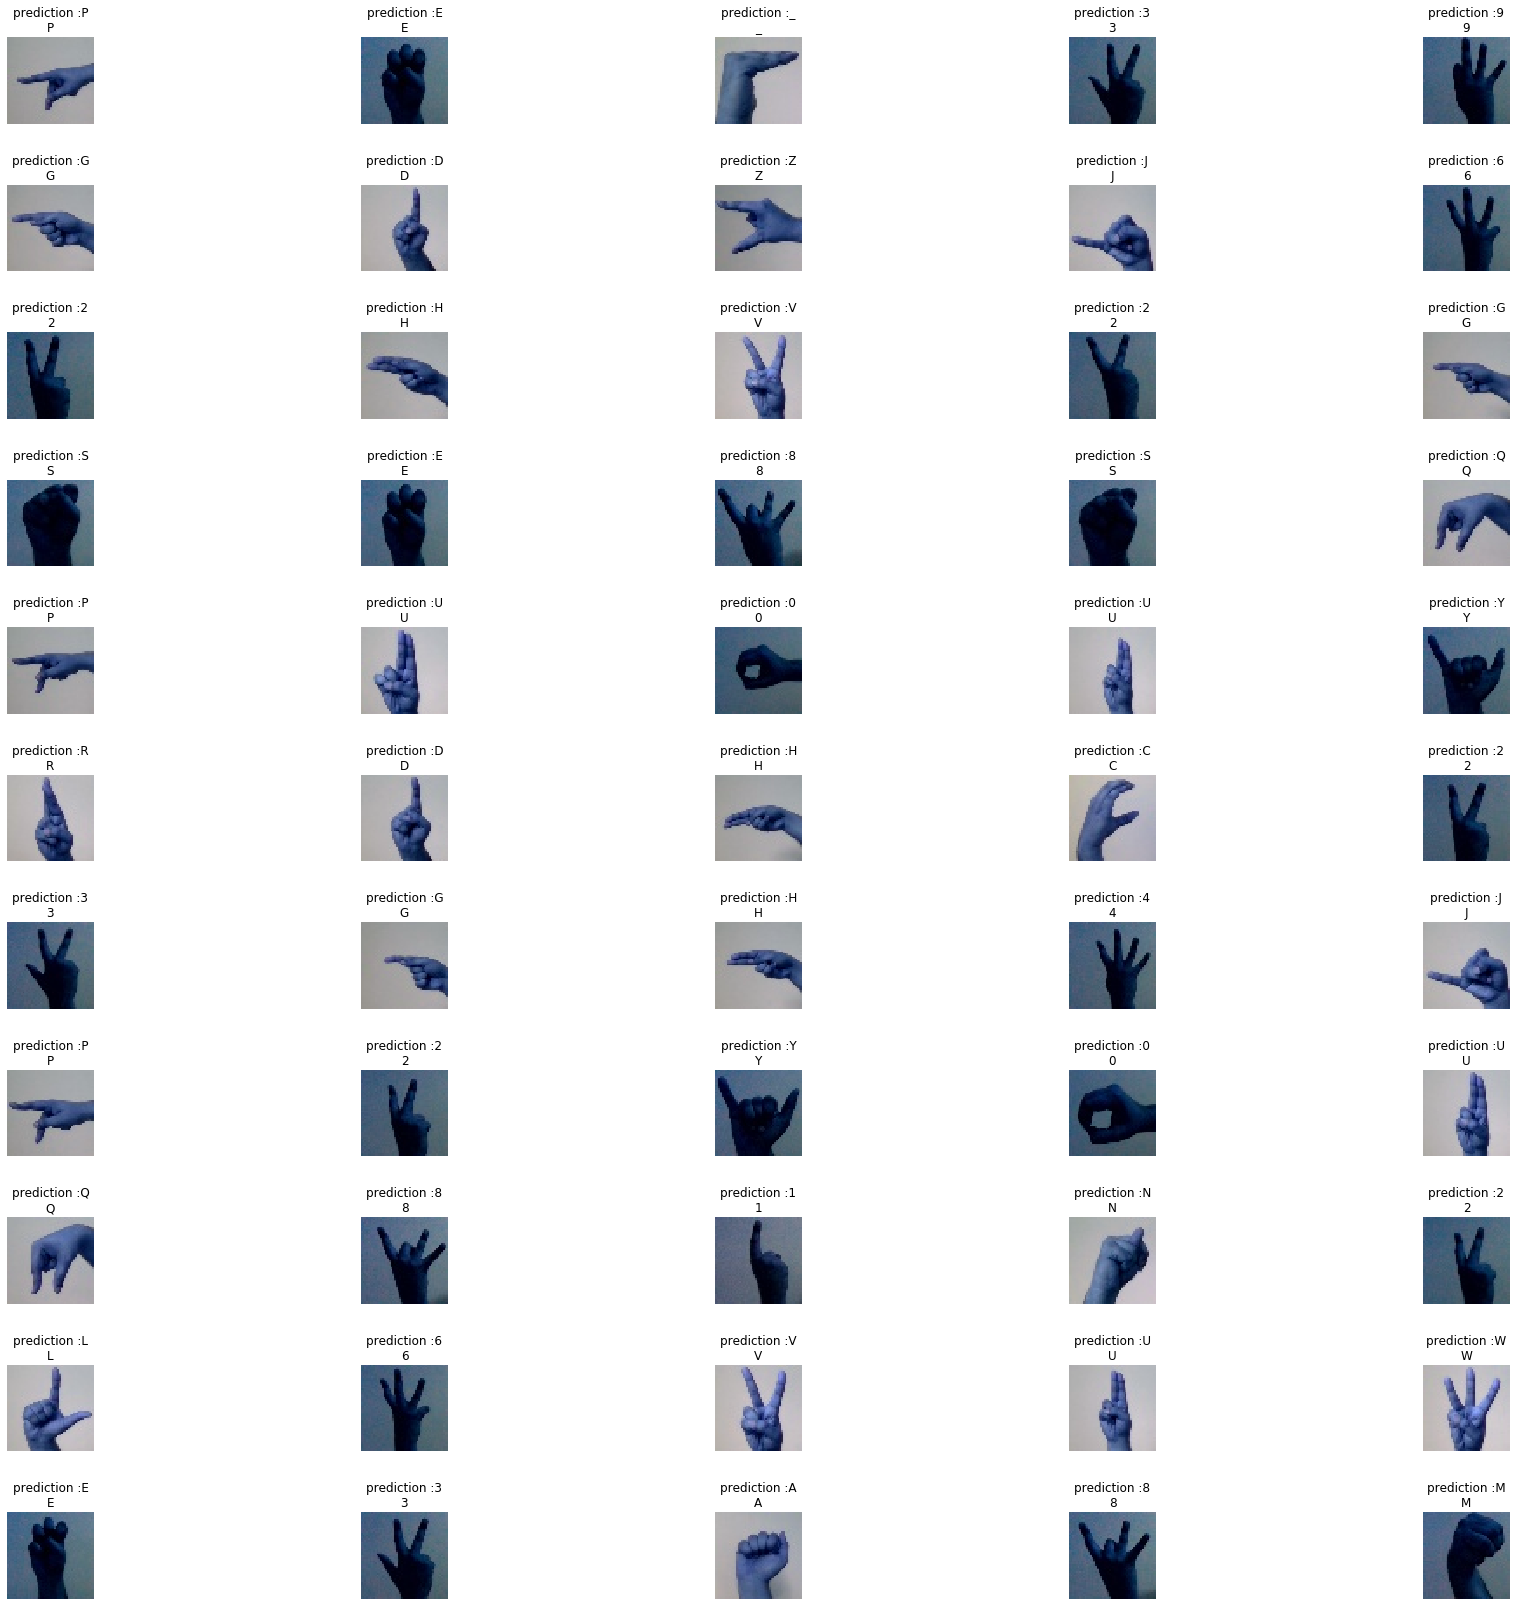

In [21]:
predfigure = plt.figure(figsize = (25,25))
def plot_image_1(fig, image, label,predictions_label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    title = "prediction :" + str(predictions_label) + "\n" + label
    plt.title(title)
    return

image_index = 0
row = 12
col = 5
for i in range(1,X_eval.shape[0]):
    plot_image_1(predfigure, X_eval[image_index], uniq_labels[Y_eval[image_index]], pred[image_index], row, col, i)
    predfigure.tight_layout(pad=3.0)
    image_index = image_index + 1
plt.show()

In [22]:
model.save('resnet50.h5')